In [ ]:
#Imports of python basic packages for data manipulation, plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Imports of system modules in python to access file manipulation features
import os
import gzip
import requests

In [ ]:
#Import of gdown python package to download shared links from gdrive
import gdown

### 1. Imagesets and labels from Zalando MNIST

Zalando gmbh provides its own MNIST imageset via github in order to serve an alternative MNIST dataset for benchmarking machine learning algorithms.
https://github.com/zalandoresearch/fashion-mnist

1.1. Importing data

Although Zalando has created the MNIST as a built-in dataset so you can access using mnist-reader or API services, since one of the purposes of this Kschool Final Project is facing realistic and down-to-earth ways to storage and access data, I decided to storage data using Google Drive and create loading function ad hoc.


In [ ]:
! pip install googledrivedownloader

In [ ]:
# Downloading Data from google drive using goolgedrivedownloader class to use ids from public links, indexing them on a dicctionary which key is id and value is the destination path in google drive
from google_drive_downloader import GoogleDriveDownloader as gdd

files_dict = {'12SqPALQ60vSpWw4qhY0Oboy1LH3Nvx6B' : './data/train_images.gz' , '18fv1neMzcDhp7BiSBDKhes_8oiBhSjuM' : './data/train_labels.gz', 
             '1TrLRhkcX7dDAP_gm0warj_sstvAW4yvb' : './data/test_images.gz', '1C4YDmgwBxAIq0Hb5ra-kwJY5qhvUs77l' : './data/test_labels.gz' }

for file_id, dest_path in files_dict.items():
  gdd.download_file_from_google_drive(file_id, dest_path, showsize=True, overwrite=True)                               

25.2 MiB Done.
0.0 B Done.
4.2 MiB Done.
0.0 B Done.


1.2. Load images as numpy array

As mentioned above, we have a loader function which reads the downloaded files path and unzip them storing into an 1 dimension array that allow us, later on, to use these image data to run our deep learning model and generate predictions.

In [ ]:
#loader for datasets returning 1 dimension array 
def load_imgset(path, kind):
  
  labels_path = os.path.join(path, '%s_labels.gz' % kind)
  images_path = os.path.join(path, '%s_images.gz' % kind)

  with gzip.open(labels_path, 'rb') as lbpath:
    labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
    
  with gzip.open(images_path, 'rb') as imgpath:   
    images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)
    
  return images, labels

Now let's use the loader function to declare train and test arrays for labels and images and store within variables.

In [ ]:
#Appy loader for each train and test set 
Xtrain, ytrain = load_imgset('./data/', kind='train')
Xtest, ytest = load_imgset('./data/', kind='test')

1.3. Exploring data

As we can see, there are train and test labelled sets which 60k and 10k items accordingly. Image dimension is 28x28px.

There are 10 different categories, from 0 to 9, which matching literal labels are also provided by Zalando.
**texto en negrita**


In [ ]:
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [ ]:
num_categories = np.unique(ytest)
num_categories

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
#Dictionary including the numerical and literal  
categ_dict = {'Label' : [0,1,2,3,4,5,6,7,8,9],
              'Description' : ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'  ]}

categ_df = pd.DataFrame(categ_dict, columns=['Label', 'Description'], index=None)

In [ ]:
categ_df

,Label,Description
0,0,T-shirt/top
1,1,Trouser
2,2,Pullover
3,3,Dress
4,4,Coat
5,5,Sandal
6,6,Shirt
7,7,Sneaker
8,8,Bag
9,9,Ankle boot


In [ ]:
categ_df.Description[ytest[0]]

'Ankle boot'

Plotting our first raw images using plt.imshow keeping in mind that our array is q line of 784 positions and must be reshaped into squared 28x28.

In [ ]:
#Import packages including keras image conversion to array just in case  

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import matplotlib.pyplot as plt
import random
from random import randrange

In [ ]:
#Plotting function which allows to quickly see a squared grid of raw images
def plot_random_grid(grid_height, grid_width):
  f, ax = plt.subplots(grid_height, grid_width, figsize=(10,10))
  k = int(grid_height*grid_width)
  random_index = np.array(random.sample(range(60000), k)).reshape(grid_height, grid_width)
  
  for i in range(0, len(random_index[0])):
    for j in range(0, len(random_index)):
      it_label = categ_df.Description[ytrain[random_index[i][j]]]

      ax[i][j].set_title(it_label)
      ax[i][j].imshow(Xtrain[random_index[i][j]].reshape(28,28))
  
  

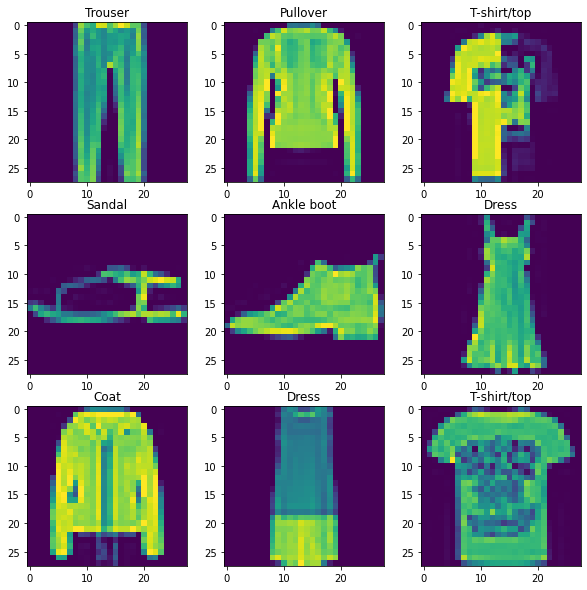

In [ ]:
plot_random_grid(3,3)

On the other hand, let's count how many images in train set per category

In [ ]:
description_arr =np.array([0] * 60000)
description_arr.reshape(60000,1)

np.vstack(description_arr)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
ytrain_t = np.vstack(ytrain)
ytrain_t

array([[9],
       [0],
       [0],
       ...,
       [3],
       [0],
       [5]], dtype=uint8)

In [ ]:
df_train = pd.DataFrame(ytrain_t, columns=['Labels'])

df_description = pd.DataFrame(description_arr, columns=['Description'] )

In [ ]:
df_labels = pd.concat([df_train,df_description])

In [ ]:
df_labels.head()

,Labels,Description
0,9.0,NaN
1,0.0,NaN
2,0.0,NaN
3,3.0,NaN
4,0.0,NaN


In [ ]:
df_labels=df_labels[df_labels['Labels'].notna()]
df_labels['Labels'] = df_labels['Labels'].astype('int64')

In [ ]:
#['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'  ]}
mapping_dict = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

In [ ]:
df_labels = df_labels['Labels'].map(mapping_dict)


In [ ]:
df_labels = pd.DataFrame(df_labels)
df_labels = df_labels.dropna()

In [ ]:
df_labels['freq'] = df_labels.groupby('Labels')['Labels'].transform('count')

In [ ]:
df_labels['freq'].unique()

array([6000])

Imageset are splitted in 10, having 6000 pcs per category

1.4. Data Preprocessing

Before using data in deep learning model, there are some preprocessing tasks which are necessary in order to make predictions and evaluate the model afterwards.

First of all, let's split train set for model evaluation and fitting

Secondly, since raw data is 1 dimension array, it is necessary to reshape it into a 28x28px format and only 1 color channel.

In [ ]:
#Validation data extraction splitting array and storing into Xval and yval.
(Xtrain, Xval) = Xtrain[6000:], Xtrain[:6000]
(ytrain, yval) = ytrain[6000:], ytrain[:6000]

In [ ]:
print(yval.shape, Xtrain.shape)

(6000,) (54000, 784)


In [ ]:
#Dataset resphaping
Xtrain = Xtrain.reshape(Xtrain.shape[0], 28, 28, 1)
Xval = Xval.reshape(Xval.shape[0], 28, 28, 1)
Xtest = Xtest.reshape(Xtest.shape[0], 28, 28, 1)

Also, in order to run the appropiate deep learning model for image classification and showing predictions, all categories should be inserted in the alghorithm as one hot encoder.

In [ ]:
#Import keras function to one hot encoding integer data
from keras.utils import to_categorical

In [ ]:
ytrain = to_categorical(ytrain, 10)
yval = to_categorical(yval, 10)
ytest = to_categorical(ytest, 10)

In [ ]:
ytrain

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Lastly, let's backup this colab session to start following notebook with this envirorment ready

In [ ]:
!pip install dill

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import dill

dill.dump_session('session.pkl')

In [ ]:
!ls '/content/'

01_nb_session.pkl  01_notebook_env.db  data  drive  sample_data  session.pkl


In [ ]:
cp session.pkl '/content/drive/MyDrive'